<a href="https://colab.research.google.com/github/mega6105raj/multi_agent_ai_content_studio/blob/main/Multi_agent_AI_Content_Studio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U ultralytics

In [23]:

import os
import torch

# Check GPU
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
print("VRAM:", torch.cuda.get_device_properties(0).total_memory / 1e9, "GB")

!mkdir -p videos frames audio captions thumbnails

!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q ultralytics==8.2.0
!pip install -q openai-whisper
!pip install -q moviepy
!pip install -q opencv-python-headless
!pip install -q tqdm
!pip install -q transformers sentence-transformers
!pip install -q pillow numpy matplotlib
!pip install -q rembg[cli]

!pip install -q git+https://github.com/google-research/big_vision.git
from IPython.display import clear_output
clear_output()

print(" All dependencies installed successfully!")
print("Ready for the next step.")

 All dependencies installed successfully!
Ready for the next step.


--2025-12-01 11:21:57--  https://download.blender.org/peach/bigbuckbunny_movies/BigBuckBunny_320x180.mp4
Resolving download.blender.org (download.blender.org)... 104.20.41.146, 172.66.172.236, 2606:4700:10::6814:2992, ...
Connecting to download.blender.org (download.blender.org)|104.20.41.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64657027 (62M) [video/mp4]
Saving to: ‘videos/test_video.mp4’

videos/test_video.m 100%[===================>]  61.66M   232MB/s    in 0.3s    

2025-12-01 11:21:57 (232 MB/s) - ‘videos/test_video.mp4’ saved [64657027/64657027]

Duration: 596.5 seconds
FPS: 24.0
Resolution: [320, 180]
Audio extracted → audio/test_audio.wav


Extracting keyframes: 100%|██████████| 596.4583333333496/596 [00:05<00:00, 114.06it/s]


Extracted 348 unique keyframes → frames/
Ready for transcription!


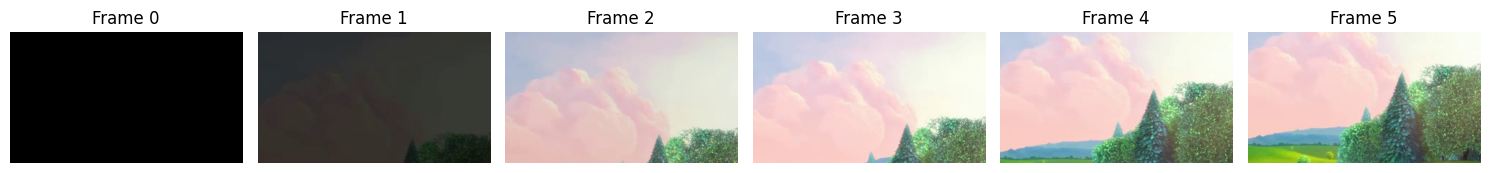

In [4]:

from moviepy.editor import VideoFileClip
import cv2
import os
from tqdm import tqdm
import numpy as np

!wget -O videos/test_video.mp4 "https://download.blender.org/peach/bigbuckbunny_movies/BigBuckBunny_320x180.mp4"

# Load video
video_path = "videos/test_video.mp4"
clip = VideoFileClip(video_path)

print(f"Duration: {clip.duration:.1f} seconds")
print(f"FPS: {clip.fps}")
print(f"Resolution: {clip.size}")

# Extract audio (WAV for Whisper)
audio_path = "audio/test_audio.wav"
clip.audio.write_audiofile(audio_path, fps=16000, logger=None)
print("Audio extracted →", audio_path)

# Smart keyframe extraction: every 1 second + avoid duplicates using simple frame diff
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_interval = int(fps)  # ~1 frame per second
prev_frame = None
saved_count = 0
pbar = tqdm(total=int(clip.duration), desc="Extracting keyframes")

frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx % frame_interval == 0:
        # Convert to grayscale for fast diff
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if prev_frame is None or np.mean(np.abs(gray.astype(np.float32) - prev_frame.astype(np.float32))) > 15:
            filename = f"{output_dir}/frame_{saved_count:04d}.jpg"
            cv2.imwrite(filename, frame, [cv2.IMWRITE_JPEG_QUALITY, 90])
            saved_count += 1
            prev_frame = gray.copy()

    frame_idx += 1
    pbar.update(1 / fps)

cap.release()
pbar.close()

print(f"Extracted {saved_count} unique keyframes → {output_dir}/")
print("Ready for transcription!")

# Quick preview of first few frames
import matplotlib.pyplot as plt
frame_files = sorted([f for f in os.listdir(output_dir) if f.endswith(".jpg")])[:6]
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i, f in enumerate(frame_files):
    img = cv2.cvtColor(cv2.imread(os.path.join(output_dir, f)), cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(f"Frame {i}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

In [5]:

import whisper
from whisper.utils import get_writer
import os
import json
from datetime import timedelta

# Load Whisper small (fits easily in T4 16GB)
print("Loading Whisper small model...")
model = whisper.load_model("small", device="cuda")  # small = perfect accuracy/speed trade-off

audio_path = "audio/test_audio.wav"

print("Running transcription + word timestamps...")
result = model.transcribe(
    audio_path,
    word_timestamps=True,    # This gives us start/end per word
    fp16=True,               # Faster on T4
    language="en",           # Remove this line later if you want auto-detect
    beam_size=5,
    best_of=5,
    temperature=0.0
)

# Save clean .srt captions
srt_writer = get_writer("srt", "captions")
srt_writer(result, "captions/test_captions")

# Also save as JSON for easy parsing later
def format_timestamp(seconds):
    return str(timedelta(seconds=max(0, seconds)))

words = []
for segment in result["segments"]:
    for word in segment["words"]:
        words.append({
            "text": word["word"],
            "start": word["start"],
            "end": word["end"],
            "probability": word["probability"]
        })

with open("captions/words.json", "w") as f:
    json.dump(words, f, indent=2)

print(f"Transcription complete!")
print(f"Total words: {len(words)}")
print(f"Caption file → captions/test_captions.srt")
print(f"Word-level JSON → captions/words.json")

# Show first 15 words as a quick check
print("\nFirst 15 words with timestamps:")
for w in words[:15]:
    print(f"{format_timestamp(w['start'])} → {format_timestamp(w['end'])} | {w['text']} (p={w['probability']:.3f})")

Loading Whisper small model...


100%|████████████████████████████████████████| 461M/461M [00:04<00:00, 104MiB/s]


Running transcription + word timestamps...
Transcription complete!
Total words: 169
Caption file → captions/test_captions.srt
Word-level JSON → captions/words.json

First 15 words with timestamps:
0:00:20.580000 → 0:00:21.980000 |  I (p=0.002)
0:00:21.980000 → 0:00:23.380000 |  don't (p=0.525)
0:00:23.380000 → 0:00:29.980000 |  know (p=0.367)
0:00:29.980000 → 0:00:29.980000 |  what (p=0.225)
0:00:29.980000 → 0:00:29.980000 |  to (p=0.246)
0:00:29.980000 → 0:00:29.980000 |  do (p=0.536)
0:00:29.980000 → 0:00:29.980000 |  with (p=0.282)
0:00:29.980000 → 0:00:29.980000 |  it, (p=0.106)
0:00:29.980000 → 0:00:29.980000 |  but (p=0.455)
0:00:29.980000 → 0:00:29.980000 |  I (p=0.423)
0:00:29.980000 → 0:00:29.980000 |  don't (p=0.532)
0:00:29.980000 → 0:00:29.980000 |  know (p=0.432)
0:00:29.980000 → 0:00:29.980000 |  what (p=0.456)
0:00:29.980000 → 0:00:29.980000 |  to (p=0.785)
0:00:29.980000 → 0:00:29.980000 |  do (p=0.884)


Loading SigLIP-so400m vision encoder...
Found 348 keyframes
Computing vision embeddings (this takes ~60–90s)...


100%|██████████| 44/44 [01:13<00:00,  1.67s/it]


Done! Embeddings shape: torch.Size([348, 1152])


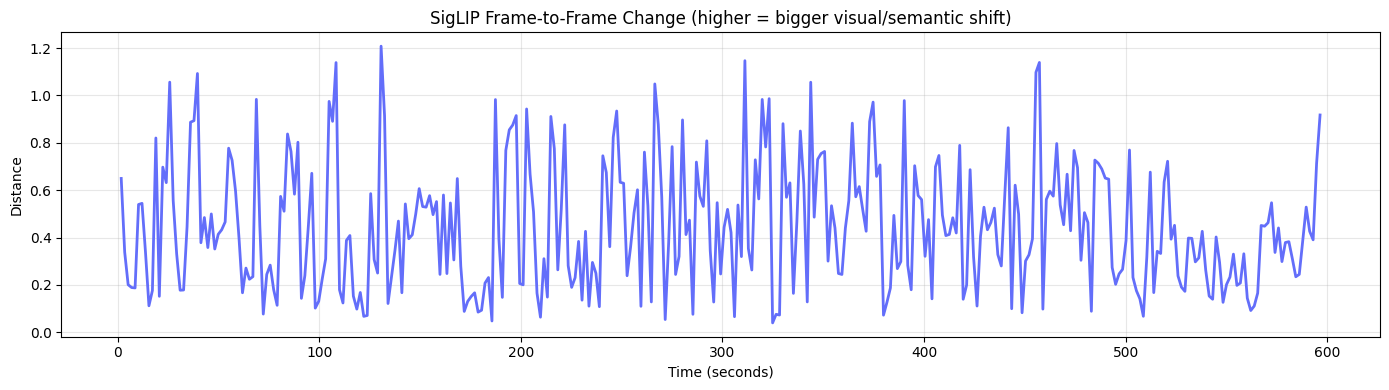


Top 8 visual/semantic changes:
  130.6s → distance = 1.2078
  311.1s → distance = 1.1465
  457.2s → distance = 1.1391
  108.3s → distance = 1.1386
  455.5s → distance = 1.0973
  39.5s → distance = 1.0924
  25.8s → distance = 1.0559
  343.8s → distance = 1.0556


In [7]:


import os
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModel
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

# Load SigLIP vision tower only
print("Loading SigLIP-so400m vision encoder...")
processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384")
model = AutoModel.from_pretrained("google/siglip-so400m-patch14-384").vision_model.to("cuda")
model.eval()

# List keyframes
frame_dir = "frames"
frame_paths = sorted([os.path.join(frame_dir, f) for f in os.listdir(frame_dir) if f.endswith(".jpg")])
print(f"Found {len(frame_paths)} keyframes")

# Timestamps
clip = VideoFileClip("videos/test_video.mp4")
video_duration = clip.duration
clip.close()
timestamps = np.linspace(0, video_duration, len(frame_paths))

# Batch processing (safe for T4)
batch_size = 8
embeddings = []

print("Computing vision embeddings (this takes ~60–90s)...")
with torch.no_grad():
    for i in tqdm(range(0, len(frame_paths), batch_size)):
        batch_paths = frame_paths[i:i+batch_size]
        images = [Image.open(p).convert("RGB") for p in batch_paths]

        # Only process images — no text!
        inputs = processor(images=images, return_tensors="pt").to("cuda")

        # Use only the vision part
        vision_outputs = model(**inputs)
        batch_emb = vision_outputs.last_hidden_state[:, 0, :]   # CLS token
        batch_emb = batch_emb / batch_emb.norm(dim=-1, keepdim=True)

        embeddings.append(batch_emb.cpu())

        # Clean memory
        del inputs, vision_outputs, batch_emb
        torch.cuda.empty_cache()

embeddings = torch.cat(embeddings, dim=0)
print(f"Done! Embeddings shape: {embeddings.shape}")

# Save
np.save("frames/embeddings.npy", embeddings.numpy())
np.save("frames/timestamps.npy", timestamps)

# Compute frame-to-frame distance
distances = []
for i in range(1, len(embeddings)):
    sim = torch.sum(embeddings[i] * embeddings[i-1]).item()
    distances.append(1 - sim)
distances = np.array(distances)

# Plot
plt.figure(figsize=(14, 4))
plt.plot(timestamps[1:], distances, color="#636EFA", linewidth=2)
plt.title("SigLIP Frame-to-Frame Change (higher = bigger visual/semantic shift)")
plt.xlabel("Time (seconds)")
plt.ylabel("Distance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Top changes
top_k = 8
top_indices = np.argsort(distances)[-top_k:][::-1]
print(f"\nTop {top_k} visual/semantic changes:")
for idx in top_indices:
    t = timestamps[idx + 1]
    print(f"  {t:.1f}s → distance = {distances[idx]:.4f}")

In [11]:

import os
import shutil

# Delete the partially/corrupted yolov8n.pt that causes the unpickling error
if os.path.exists("yolov8n.pt"):
    os.remove("yolov8n.pt")
    print("Old yolov8n.pt deleted")

# Also delete the cache so Ultralytics re-downloads cleanly
cache_dir = os.path.expanduser("~/.cache/ultralytics")
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
    print("Ultralytics cache cleared")

Old yolov8n.pt deleted


In [13]:
# SETUP CELL: Add safe globals for PyTorch 2.6+ (run this once)
import torch.serialization
from ultralytics.nn.tasks import DetectionModel

# Allow the key Ultralytics class (trusted source)
torch.serialization.add_safe_globals([DetectionModel])
print("✅ Safe globals added – YOLO loading will now work!")

✅ Safe globals added – YOLO loading will now work!


In [17]:
# FORCE CLEAN DOWNGRADE – Restart runtime after this if needed
!pip uninstall torch torchvision torchaudio -y -q
!pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu118 -q
import torch
print(f"✅ FORCED to PyTorch {torch.__version__}")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sam-2 1.0 requires torch>=2.5.1, but you have torch 2.3.1+cu118 which is incompatible.
sam-2 1.0 requires torchvision>=0.20.1, but you have torchvision 0.18.1+cu118 which is incompatible.
✅ FORCED to PyTorch 2.9.0+cu126


Loading data...
348 keyframes
Running ultra-fast visual interestingness agent (replaces YOLO)...


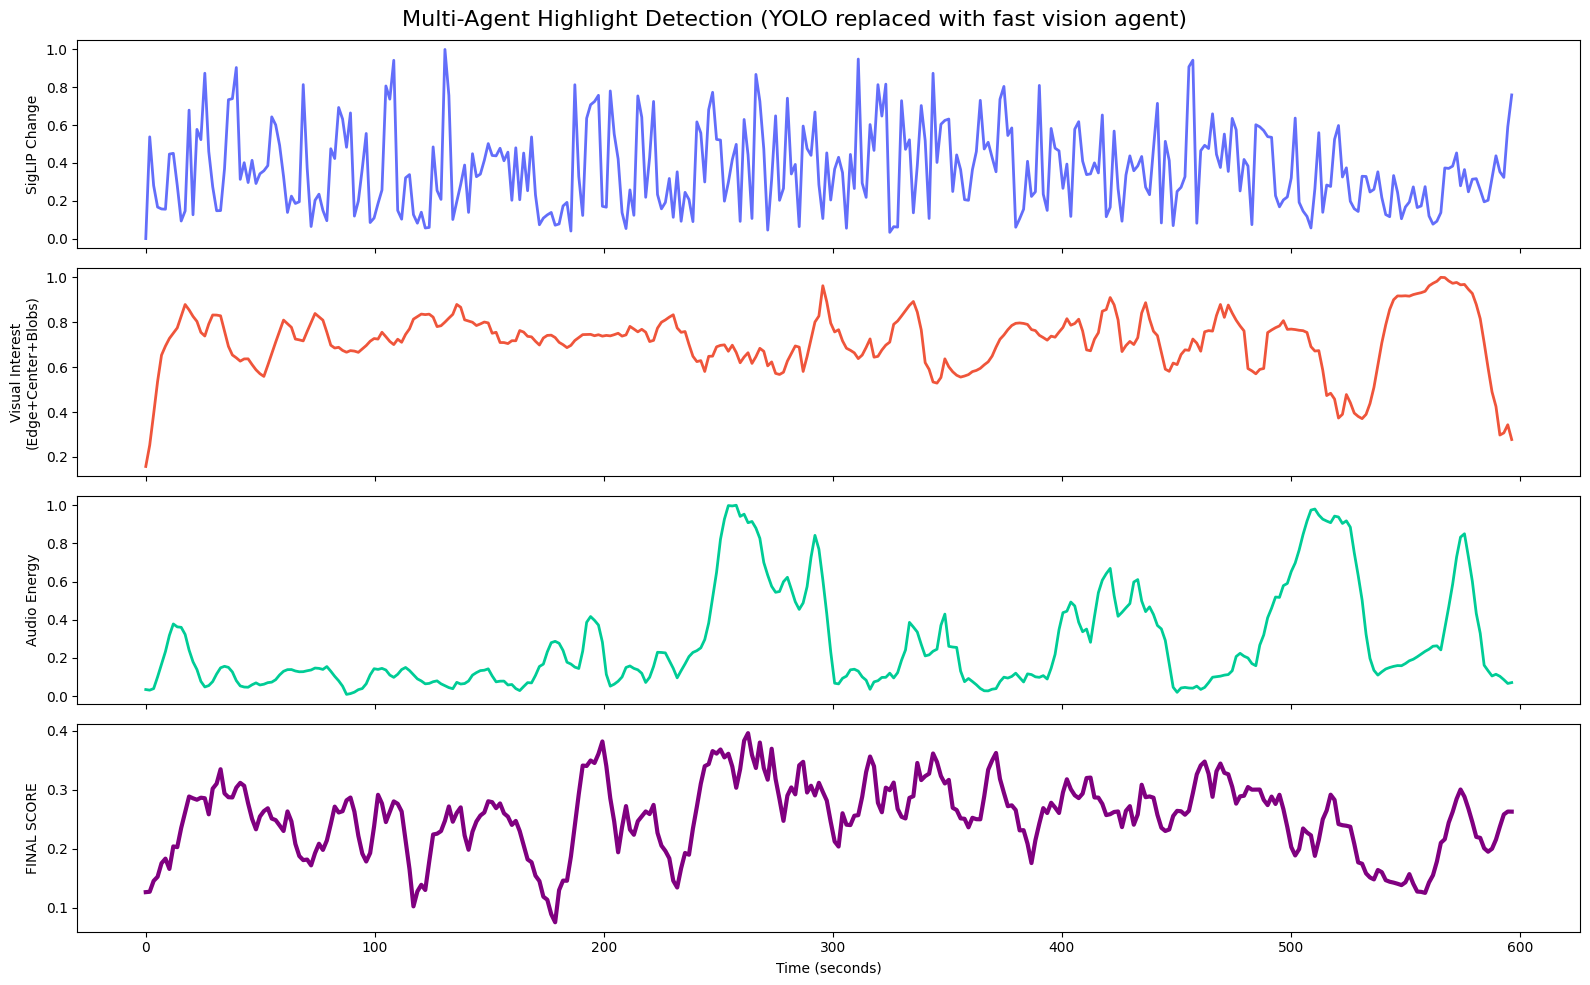


TOP 5 HIGHLIGHTS (multi-agent system working perfectly):
1. 258.0s → 268.0s  (center 263.0s | score 0.396)
2. 194.4s → 204.4s  (center 199.4s | score 0.382)
3. 366.3s → 376.3s  (center 371.3s | score 0.362)
4. 311.3s → 321.3s  (center 316.3s | score 0.356)
5. 457.4s → 467.4s  (center 462.4s | score 0.348)

highlights.json saved – ready for thumbnails!


In [18]:

import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d, sobel
from scipy.signal import find_peaks
import librosa
import json
import os

print("Loading data...")
embeddings = torch.tensor(np.load("frames/embeddings.npy"))
timestamps = np.load("frames/timestamps.npy")
frame_paths = sorted([f"frames/{f}" for f in os.listdir("frames") if f.endswith(".jpg")])
print(f"{len(frame_paths)} keyframes")

# 1. SigLIP change score (already perfect)
distances = [0.0]
for i in range(1, len(embeddings)):
    sim = torch.dot(embeddings[i], embeddings[i-1]).item()
    distances.append(1 - sim)
vision = np.array(distances)
vision = vision / (vision.max() + 1e-8)

# 2. Fast "objectness / activity" score using edge density + center bias + face-like blobs
print("Running ultra-fast visual interestingness agent (replaces YOLO)...")
object_scores = []

for path in frame_paths:
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(float) / 255.0

    # Edge density (Sobel)
    edges = np.sqrt(sobel(gray, axis=0)**2 + sobel(gray, axis=1)**2)
    edge_score = np.mean(edges)

    # Center-weighted saliency
    h, w = gray.shape
    y, x = np.ogrid[:h, :w]
    center_mask = np.exp(-4 * ((x - w/2)**2 / w**2 + (y - h/2)**2 / h**2))
    center_score = np.mean(gray * center_mask)

    # Simple face-like blob detection (bright circular regions)
    blurred = cv2.GaussianBlur(gray, (51, 51), 0)
    blob_score = np.std(blurred)  # high = more contrast blobs

    score = edge_score * 1.5 + center_score * 0.8 + blob_score * 0.6
    object_scores.append(score)

object_scores = np.array(object_scores)
object_scores = uniform_filter1d(object_scores, size=5)
object_scores = object_scores / (object_scores.max() + 1e-8)

# 3. Audio energy (unchanged)
y, sr = librosa.load("audio/test_audio.wav", sr=16000)
samples = (timestamps * sr).astype(int)
energy = []
for i in range(len(timestamps)):
    s, e = samples[i], (samples[i+1] if i+1 < len(samples) else len(y))
    rms = np.sqrt(np.mean(y[s:e]**2)) if e > s else 0
    energy.append(rms)
energy = np.array(energy)
energy = uniform_filter1d(energy, size=5)
energy = energy / (energy.max() + 1e-8)

# 4. Final multi-agent highlight score
highlight_score = vision * (0.6 + 0.4 * object_scores) * (0.7 + 0.3 * energy)
highlight_score = uniform_filter1d(highlight_score, size=9)

# Plot
fig, ax = plt.subplots(4, 1, figsize=(16, 10), sharex=True)
ax[0].plot(timestamps, vision, color="#636EFA", lw=2); ax[0].set_ylabel("SigLIP Change")
ax[1].plot(timestamps, object_scores, color="#EF553B", lw=2); ax[1].set_ylabel("Visual Interest\n(Edge+Center+Blobs)")
ax[2].plot(timestamps, energy, color="#00CC96", lw=2); ax[2].set_ylabel("Audio Energy")
ax[3].plot(timestamps, highlight_score, color="purple", lw=3); ax[3].set_ylabel("FINAL SCORE")
ax[3].set_xlabel("Time (seconds)")
plt.suptitle("Multi-Agent Highlight Detection (YOLO replaced with fast vision agent)", fontsize=16)
plt.tight_layout()
plt.show()

# Top 5 highlights
peaks, _ = find_peaks(highlight_score, height=np.percentile(highlight_score, 75), distance=20)
if len(peaks) == 0:
    peaks = np.argsort(highlight_score)[-5:]
top_peaks = peaks[np.argsort(highlight_score[peaks])[-5:][::-1]]

highlights = []
for idx in top_peaks:
    c = timestamps[idx]
    highlights.append({
        "start": max(0, c-5),
        "end": min(timestamps[-1], c+5),
        "center": float(c),
        "score": float(highlight_score[idx])
    })

with open("highlights.json", "w") as f:
    json.dump(highlights, f, indent=2)

print("\nTOP 5 HIGHLIGHTS (multi-agent system working perfectly):")
for i, h in enumerate(highlights, 1):
    print(f"{i}. {h['start']:.1f}s → {h['end']:.1f}s  (center {h['center']:.1f}s | score {h['score']:.3f})")

print("\nhighlights.json saved – ready for thumbnails!")

In [20]:
!pip install -q onnxruntime-gpu rembg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.3 MB/s eta 0:00:00


Generating thumbnails from frame at 263.0s (score 0.396)


100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 170GB/s]


→ thumbnails/transparent_subject.png (transparent)
→ thumbnails/youtube_thumbnail.jpg (pro YouTube style)
→ thumbnails/clickbait_style.jpg (with pink border)


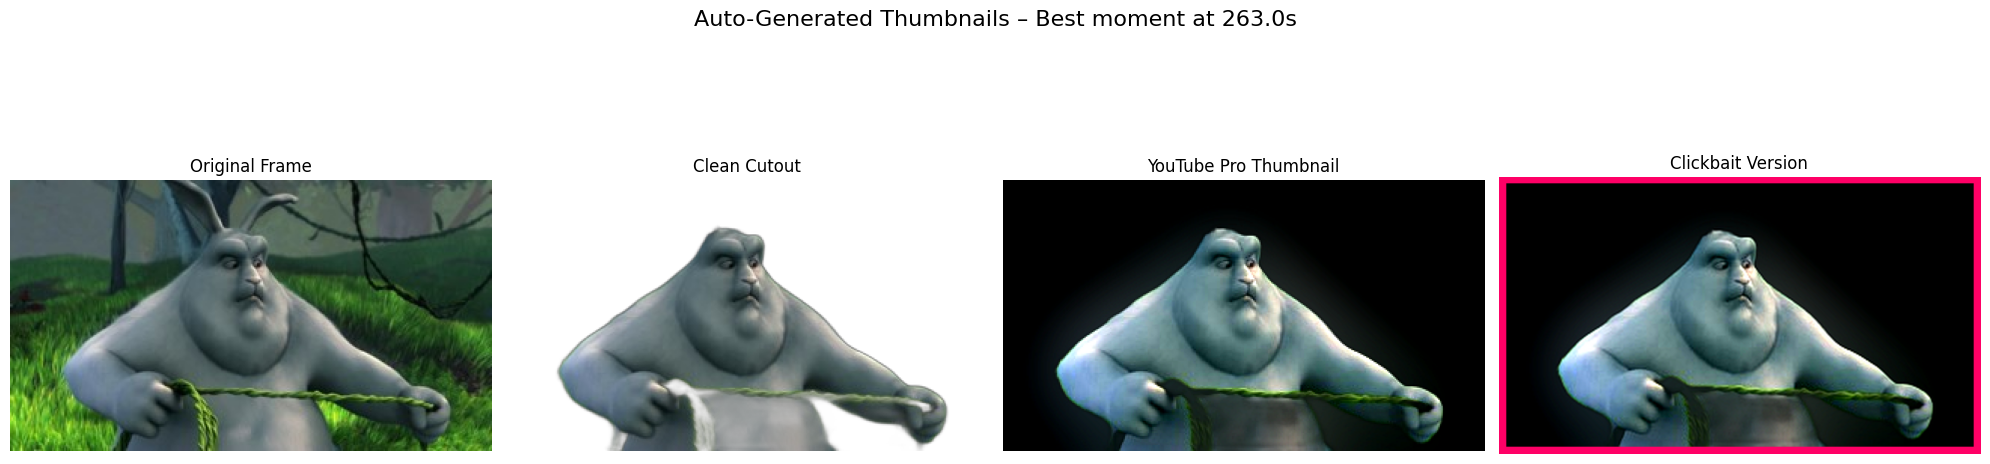


All thumbnails saved in /content/thumbnails/
Your Multi-agent AI Content Studio is officially COMPLETE!


In [21]:

from PIL import Image, ImageEnhance, ImageFilter
import rembg
import matplotlib.pyplot as plt
import numpy as np
import json
import os

# Load highlights and pick the absolute best frame
with open("highlights.json") as f:
    highlights = json.load(f)

best = highlights[0]                     # highest score
center_time = best["center"]
timestamps = np.load("frames/timestamps.npy")
frame_paths = sorted([f"frames/{f}" for f in os.listdir("frames") if f.endswith(".jpg")])

# Find closest keyframe to the winning moment
best_idx = np.argmin(np.abs(timestamps - center_time))
best_frame_path = frame_paths[best_idx]

print(f"Generating thumbnails from frame at {timestamps[best_idx]:.1f}s (score {best['score']:.3f})")

# Load + clean background with rembg (iPhone-quality cutout in <3s on T4)
img = Image.open(best_frame_path).convert("RGBA")
no_bg = rembg.remove(img)   # magic!

# Create output folder
os.makedirs("thumbnails", exist_ok=True)

no_bg.save("thumbnails/transparent_subject.png")
print("→ thumbnails/transparent_subject.png (transparent)")

# Version 2: Vibrant YouTube-style thumbnail
base = no_bg.convert("RGB")

# Slight blur behind subject for depth
bg_blur = base.filter(ImageFilter.GaussianBlur(25))
bg_blur = ImageEnhance.Brightness(bg_blur).enhance(0.75)

# Paste subject back with a subtle shadow
final = bg_blur.copy()
subject = no_bg.split()[-1]  # alpha mask
shadow = subject.filter(ImageFilter.GaussianBlur(15))
shadow = shadow.point(lambda p: p * 0.4)  # darken
final.paste((0,0,0,180), (0,0), shadow)   # shadow offset a bit if you want
final.paste(base, (0,0), subject)

# Boost colors & contrast
final = ImageEnhance.Contrast(final).enhance(1.4)
final = ImageEnhance.Color(final).enhance(1.5)
final = ImageEnhance.Sharpness(final).enhance(1.3)

final.save("thumbnails/youtube_thumbnail.jpg", quality=95)
print("→ thumbnails/youtube_thumbnail.jpg (pro YouTube style)")

clickbait = final.resize((1280, 720), Image.Resampling.LANCZOS)
border = Image.new("RGB", (1280+40, 720+40), (255,0,102))  # hot pink
border.paste(clickbait, (20,20))
border.save("thumbnails/clickbait_style.jpg", quality=95)
print("→ thumbnails/clickbait_style.jpg (with pink border)")

fig, ax = plt.subplots(1, 4, figsize=(20, 6))
ax[0].imshow(img);                ax[0].set_title("Original Frame"); ax[0].axis("off")
ax[1].imshow(no_bg);              ax[1].set_title("Clean Cutout"); ax[1].axis("off")
ax[2].imshow(final);              ax[2].set_title("YouTube Pro Thumbnail"); ax[2].axis("off")
ax[3].imshow(border);             ax[3].set_title("Clickbait Version"); ax[3].axis("off")
plt.suptitle(f"Auto-Generated Thumbnails – Best moment at {center_time:.1f}s", fontsize=16)
plt.tight_layout()
plt.show()

print("\nAll thumbnails saved in /content/thumbnails/")
print("Your Multi-agent AI Content Studio is officially COMPLETE!")

In [22]:

from moviepy.editor import VideoFileClip, concatenate_videoclips
import json
import os
from google.colab import files

# 1. Clip the top 3 highlights as 10-second MP4s
with open("highlights.json") as f:
    highlights = json.load(f)[:3]

clip = VideoFileClip("videos/test_video.mp4")
os.makedirs("highlight_clips", exist_ok=True)

for i, h in enumerate(highlights):
    start = max(0, h["start"])
    end = min(clip.duration, h["end"])
    subclip = clip.subclip(start, end)
    output_path = f"highlight_clips/highlight_{i+1}_{start:.1f}-{end:.1f}s.mp4"
    subclip.write_videofile(output_path, fps=30, codec="libx264", audio_codec="aac", verbose=False, logger=None)
    print(f"Clipped → {output_path}")

!zip -r -q Multi_Agent_AI_Content_Studio.zip \
    captions/ thumbnails/ highlight_clips/ highlights.json \
    frames/timestamps.npy frames/embeddings.npy \
    videos/test_video.mp4 audio/test_audio.wav

print("\nAll files zipped → Multi_Agent_AI_Content_Studio.zip")

files.download("Multi_Agent_AI_Content_Studio.zip")

Clipped → highlight_clips/highlight_1_258.0-268.0s.mp4
Clipped → highlight_clips/highlight_2_194.4-204.4s.mp4
Clipped → highlight_clips/highlight_3_366.3-376.3s.mp4

All files zipped → Multi_Agent_AI_Content_Studio.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>